In [75]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression


from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
matplotlib.rcParams.update({'font.size': 14})

In [39]:
test_df = pd.read_csv('test.csv', sep=',')
train_df = pd.read_csv('train.csv', sep=',')

In [40]:
# train_df.dtypes

Приведение типов данных

In [41]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [42]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [43]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64', 'float32', 'float16'])
test_df_num_features = test_df.select_dtypes(include=['float64', 'int64', 'float32', 'float16'])

train_df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.871089
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.720850
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.007630
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.102962


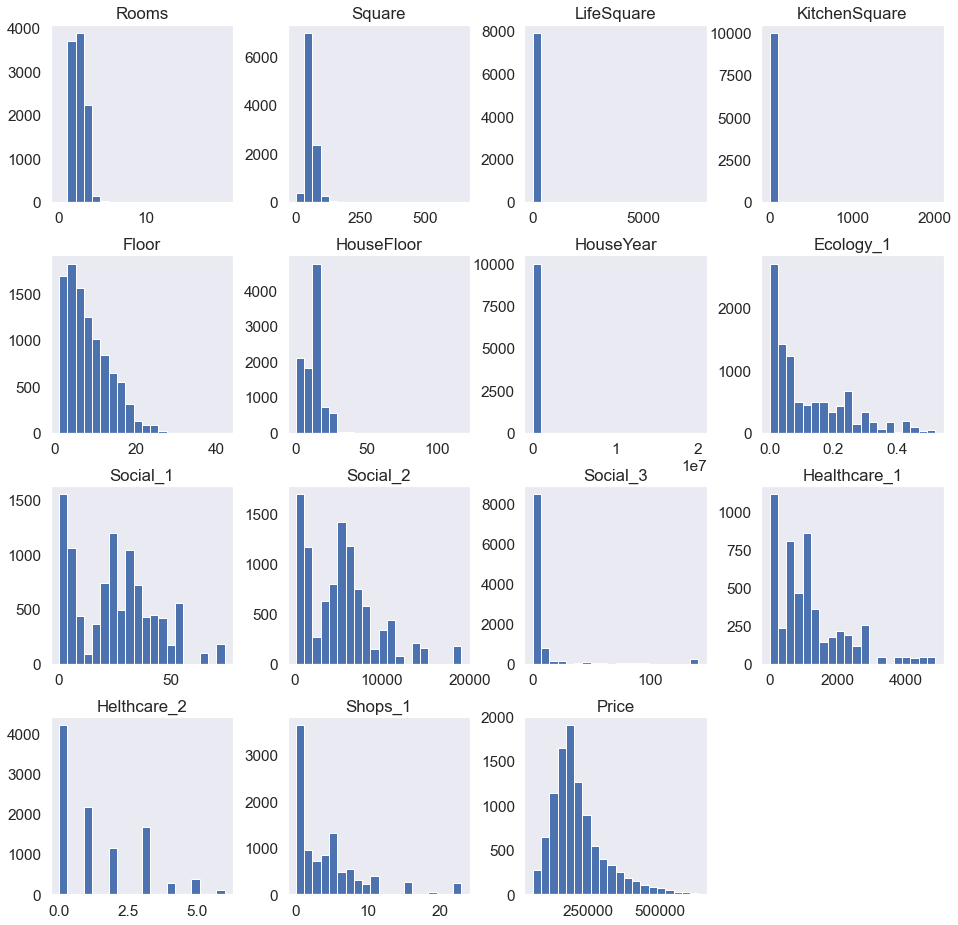

In [44]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64', 'float32', 'float16'])

df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Data outliers curation:

In [45]:
# train_df.dtypes

In [46]:
def plot(column_name):
    plt.figure(figsize = (16, 8))

    train_df[column_name].hist(bins=30)
    plt.ylabel('Count')
    plt.xlabel(column_name)

    plt.title('Target distribution')
    plt.show()

In [47]:
# plot('HouseYear')

Rooms

In [48]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [49]:
# train_df.loc[(train_df['Rooms'] < 1) | (train_df['Rooms'] >5)] = 1 
# train_df['Rooms'].value_counts()

KitchenSquare

<AxesSubplot:xlabel='Social_3'>

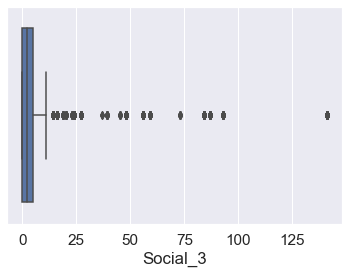

In [50]:
sns.boxplot(train_df['Social_3'])

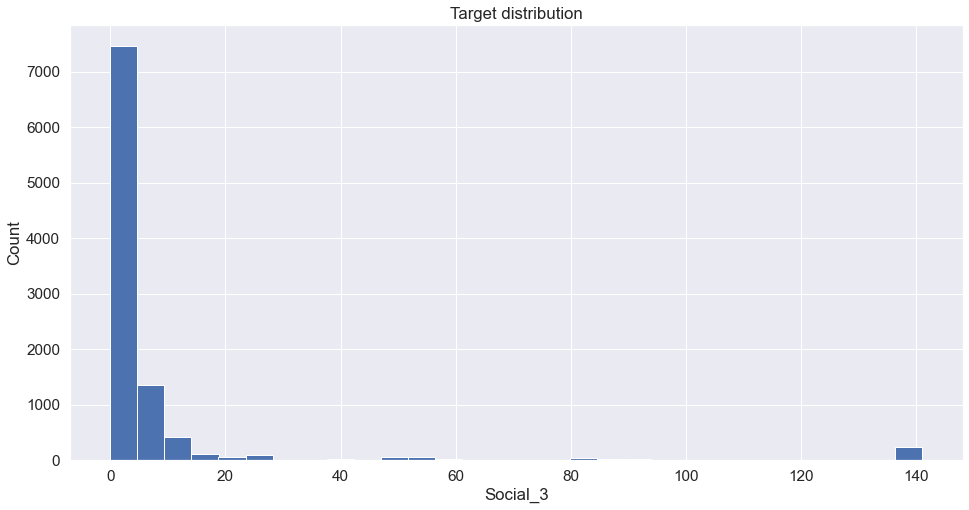

In [51]:
plot('Social_3')

In [52]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.stat_dict = None
        
        
    def fit(self, X):
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975) 
        
#         getting dict for each numerical column containing Quartiles
        self.stat_dict = {}
        IQR = 0
        up_lim = 0

        for column_name in list(df_num_features): 
            q1_25 = np.percentile(train_df_num_features[column_name], 25, interpolation = 'midpoint')  
            q3_75 = np.percentile(train_df_num_features[column_name], 75, interpolation = 'midpoint')
            IQR = q3_75 - q1_25
            up_lim = q3_75 + 1.5 * IQR
            self.stat_dict[column_name] = [q1_25, q3_75, IQR, up_lim]
     
    
#     def transform(self, X):
    def rooms(self, X):
        
        # Rooms. Zero rooms seems to be an outlier so it would be better to substitute it with at least 1 room
        # all of the rooms exceeded 5 were replaced by median         
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >5, 'Rooms'] = self.medians['Rooms']
        
        
        

    def kitchen(self, X):    
        # KitchenSquare. Calculated quartiles are used to substitute missed KitchenSquare

        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.stat_dict['KitchenSquare'][3])
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 4
       
    def lifesquare(self, X):   
        
        # LIFESQUARE
        
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - np.pi
        
        X.loc[X['LifeSquare'] > 300, 'LifeSquare'] = self.medians['LifeSquare']
        X.fillna(self.medians, inplace=True)
        
        
        
    def floor(self, X):        
        # Floor  
        # HouseFloor, Floor
        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] >60, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
#         X.drop(['HouseFloor_outlier'], axis = 1)
        
        
        
    def year(self, X):
        # HouseYear
        
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
#         X.drop(['HouseYear_outlier'], axis = 0)
        
        
        
        # обработка пропусков
        
        
    
    def social_3(self, X):
        
        X.loc[X['Social_3'] > self.stat_dict['Social_3'][3] , 'Social_3'] = self.medians['Social_3']
        

    def missing(self, X):
        X['LifeSquare'] = X['LifeSquare'].interpolate(method='linear', limit_direction='forward', axis=0)
        X['LifeSquare'] = X['LifeSquare'].fillna(self.medians['Healthcare_1'])
        X['Healthcare_1'] = X['Healthcare_1'].interpolate(method='linear', limit_direction='forward', axis=0)
        X['Healthcare_1'] = X['Healthcare_1'].fillna(self.medians['Healthcare_1'])
        
        
       

In [53]:
dp = DataPreprocessing()
dp.fit(train_df)

dp.missing(train_df)

dp.rooms(train_df)
dp.kitchen(train_df)
dp.lifesquare(train_df)
dp.floor(train_df)
dp.year(train_df)
dp.social_3(train_df)




Построение новых признаков

In [54]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1960), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1960, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [55]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1960, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [56]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'HouseFloor_outlier',
 'HouseYear_outlier']

In [57]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']
new_feature_names = ['HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']


['Rooms_outlier', 'LifeSquare_nan', 'HouseFloor_outlier', 'HouseYear_outlier']
target_name = 'Price'

In [58]:
test_df = pd.read_csv('test.csv', sep=',')
train_df = pd.read_csv('train.csv', sep=',')

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)




    

In [60]:
dp = DataPreprocessing()

def preprocessor(X):
    dp.fit(X)
    dp.missing(X)
    dp.rooms(X)
    dp.kitchen(X)
    dp.lifesquare(X)
    dp.floor(X)
    dp.year(X)
    dp.social_3(X)
    
    return X
    
  

In [61]:
X_train = preprocessor(X_train) 
X_valid = preprocessor(X_valid) 
test_df = preprocessor(test_df)

In [62]:
X_train.shape, X_valid.shape, test_df.shape


((6700, 22), (3300, 22), (5000, 22))

In [63]:
# X_train.shape, X_valid.shape, test_df.shape

In [64]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

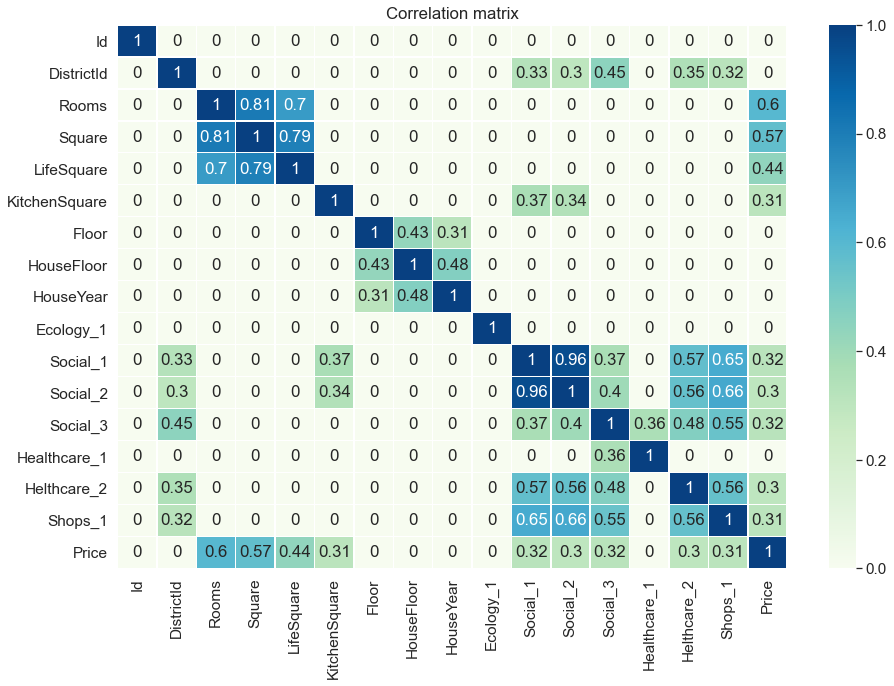

In [65]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr(method='spearman')
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [66]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

# окинув взглядом матрицу корреляции, решил выкинуть признаки с нулевой корреляцией 
X_train = X_train.drop(['Floor', 'HouseFloor','HouseYear', 'Ecology_1', 'LifeSquare_nan', 'new_district'], axis = 1)
X_valid = X_valid.drop(['Floor', 'HouseFloor','HouseYear', 'Ecology_1', 'LifeSquare_nan', 'new_district'], axis = 1)
test_df = test_df.drop(['Floor', 'HouseFloor','HouseYear', 'Ecology_1', 'LifeSquare_nan', 'new_district'], axis = 1)

In [67]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [68]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [69]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

Построение модели

In [ ]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

# y_train_preds = gb_model.predict(X_train)
# y_test_preds = gb_model.predict(test_df)
# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [143]:
# y_train_preds = gb_model.predict(X_train)
# y_test_preds = gb_model.predict(test_df)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

test_df.shape

(5000, 18)

In [146]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [147]:
predictions = gb_model.predict(test_df)
predictions
submit['Price'] = predictions


In [149]:
submit.to_csv('gb_submit.csv', index=False)